<font face="B Mitra" size=4>
<div dir=ltr align=center>
<br>
<img src="https://aut.ac.ir/templates/tmpl_modern01/images/logo_fa.png" alt="Amirkabir University Logo" width="100">
<br>
<font size=6>
<b>Data Mining - Project </b>
<br>
<font size=5> Course Instructor: Dr. Fatemeh Shakeri
<br>
<font size=5> Project Designers: Mehdi Rajabi, Mehdi Ghayathi, Sina Arzbin
<br>
<font size=4> Fall 2024
<hr>
</div>
</font>


In [ ]:
!pip install dash

In [ ]:

import numpy as np

import pandas as pd
import pickle

# Plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')
# %config InlineBackend.figure_formats = ['svg']
import seaborn as sns

# Used to draw a progress bar for longer method calls
from tqdm import tqdm
tqdm.pandas()

# Pre-trained natural language processing pipeline
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

# Used to import list of punctuations
import string

# Feature extraction (text vectorizers)
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora.dictionary import Dictionary

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Clustering and evaluation
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer


# Topic modeling
from gensim.models import LdaModel
from gensim.models import Nmf
from gensim.models.coherencemodel import CoherenceModel

# Wordcloud
from wordcloud import WordCloud

# Grid search
from sklearn.model_selection import ParameterGrid

<div dir=ltr>
<h2>
<font face="B Nazanin" color="#0099cc">
Dataset Loading


In [ ]:
df = pd.read_csv('./bbc-news-data.csv', sep='\t')
df.head(5)

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


<div dir=ltr>
<h2>
<font face="B Nazanin" color="#0099cc">
Preprocessing


<div dir=ltr>
<h4>
<font face="B Nazanin">
<b>1. Tokenization, Punctuation Removal, and Lemmatization</b>
</font>
</h4>
<div dir=ltr>
<font face="B Nazanin" size=4>
In this section, various preprocessing steps should be applied to the texts:
<ol>
    <li>Tokenizing the texts</li>
    <li>Converting all letters to lowercase</li>
    <li>Removing punctuation marks</li>
    <li>Removing stop words</li>
    <li>Lemmatization</li>
    <li>Removing pronouns</li>
    <li>Removing numbers</li>
    <li>Removing words shorter than three letters</li>
</ol>
The processed texts should be stored in the <code>processed_content</code> column.
</font>
</p>
</div>


<div dir=ltr>
<font face="B Nazanin" size=4>
Note: Pay attention to the order of the above steps. The given order is not necessarily correct.
</font>
</p>



In [ ]:



nlp = spacy.load('en_core_web_sm')


df = pd.read_csv('./bbc-news-data.csv', sep='\t')


def tokenize_text(text):
    doc = nlp(text)

    return [token.lemma_ for token in doc]

df['tokens_lemmatized'] = df['content'].apply(tokenize_text)


df['tokens_lower'] = df['tokens_lemmatized'].apply(lambda tokens: [token.lower() for token in tokens])


def remove_punctuations(tokens):
    return [token for token in tokens if token not in string.punctuation]

df['tokens_no_punct'] = df['tokens_lower'].apply(remove_punctuations)










def filter_tokens(tokens):
    doc = nlp(' '.join(tokens))
    return [token.text for token in doc if not token.is_digit and len(token.text) > 2 and token.pos_ != 'PRON']

df['final_tokens'] = df['tokens_no_punct'].apply(filter_tokens)


def remove_stopwords(tokens):
    return [token for token in tokens if token not in STOP_WORDS]

df['tokens_no_stopwords'] = df['final_tokens'].apply(remove_stopwords)
df['processed_content'] = df['tokens_no_stopwords'].apply(lambda tokens: ' '.join(tokens))

print("داده‌های پردازش‌شده:")
print(df[['content', 'processed_content']].head())





داده‌های پردازش‌شده:
                                             content  \
0   Quarterly profits at US media giant TimeWarne...   
1   The dollar has hit its highest level against ...   
2   The owners of embattled Russian oil giant Yuk...   
3   British Airways has blamed high fuel prices f...   
4   Shares in UK drinks and food firm Allied Dome...   

                                   processed_content  
0  quarterly profit media giant timewarner jump 1...  
1  dollar hit high level euro month federal reser...  
2  owner embattle russian oil giant yukos ask buy...  
3  british airways blame high fuel price drop pro...  
4  drink food firm allied domecq speculation targ...  


<div dir=ltr>
<font face="B Nazanin" size=4>
The common stop words provided by libraries do not include all unnecessary words.  
In this section, first, find the frequency of each word in the tokenized data.  
Then, from the top 100 most frequent words, identify those that you consider unimportant  
and add them to the stop words list for removal.
</font>
</p>
</div>


In [ ]:
from collections import Counter


word_freq = Counter()
for tokens in df['tokens_no_stopwords']:
    word_freq.update(tokens)


most_common_100 = word_freq.most_common(100)

print("100 کلمه پرتکرار:")
print(most_common_100)


new_stop_words = [
    'win','time','year','people','new','good','use','come','work','tell','want','add','like','think','number','include','way','set','week',
    'day','need','plan','big','look','know','second','million','expect','rise','help','find','right',
    'end','start','try','offer','claim','lead','early','share','long','change','hold','issue','follow',
    'great','open','user','point','half','increase','deal','mean'
]


STOP_WORDS.update([word.lower() for word in new_stop_words])

df['final'] = df['tokens_no_stopwords'].apply(lambda tokens: remove_stopwords(tokens))
df['processed_content'] = df['final'].apply(lambda tokens: ' '.join(tokens))

print("نمونه ای از داده پردازش شده:")
print(df[['content', 'processed_content']].head())


100 کلمه پرتکرار:
[('win', 1429), ('game', 1423), ('world', 1205), ('government', 1194), ('play', 1164), ('film', 1116), ('company', 1107), ('firm', 971), ('month', 884), ('service', 848), ('country', 837), ('market', 829), ('player', 822), ('high', 816), ('music', 815), ('party', 790), ('labour', 774), ('report', 759), ('bbc', 751), ('home', 736), ('election', 721), ('sale', 712), ('minister', 712), ('technology', 663), ('mobile', 627), ('group', 622), ('phone', 605), ('england', 596), ('run', 593), ('old', 571), ('public', 556), ('blair', 553), ('star', 539), ('record', 538), ('british', 536), ('system', 532), ('believe', 525), ('pay', 520), ('place', 519), ('european', 518), ('news', 513), ('award', 508), ('price', 507), ('cost', 507), ('man', 492), ('business', 487), ('director', 481), ('face', 480), ('sell', 475), ('fall', 473), ('bank', 467), ('base', 466), ('life', 466), ('team', 466), ('problem', 465), ('industry', 461), ('lose', 459), ('chief', 459), ('hope', 458), ('law', 458

<div dir=ltr>
<font face="B Nazanin" size=4>
Since the above process is somewhat time-consuming,  
you can run it once and save the DataFrame using the following block.
</font>
</p>
</div>


In [ ]:
import pickle
pickle.dump(df, open("processed_df.pkl", "wb"))


<div dir=ltr>
<font face="B Nazanin" size=4>
By running the block below, you can also load the saved DataFrame.
</font>
</p>
</div>


In [ ]:
df = pickle.load(open("processed_df.pkl", "rb"))

<div dir=ltr>
<h4>
<font face="B Nazanin">
<b>2. Feature Extraction from Texts</b>
</font>
</h4>
<div dir=ltr>
<font face="B Nazanin" size=4>
Construct the feature matrix for the texts using  
<code>TfidfVectorizer</code>.
</font>
</p>
</div>


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


corpus = [' '.join(tokens) for tokens in df['final']]


vectorizer = TfidfVectorizer(max_features=8192)


X_tfidf = vectorizer.fit_transform(corpus)


print("ابعاد ماتریس TF-IDF:", X_tfidf.shape)


ابعاد ماتریس TF-IDF: (2225, 8192)


<div dir=ltr>
<font face="B Nazanin" size=4>
What is the rationale behind TF-IDF feature extraction?  
How does it differ from simply counting word frequency in each text?
</font>
</p>
</div>



<font face="B Nazanin">
<div dir=ltr>
<p align="justify">
<font size=4>
<b> <font color='#eb4034'>Explanation of the Answer: </font></b>  
When we simply count the words, a word may appear in many texts, and therefore, it shouldn't have much influence on our clustering as it is not a specific word. However, in this method, such words become influential and are considered among the most important words of the topic. In TF-IDF, words whose frequency is high because they are just common words are given less importance by calculating the logarithm of the total number of documents divided by the number of documents containing that word. As a result, the importance of such words decreases.
</p>
</font>
</div>
</font>
<hr>


<div dir=ltr>
<h2>
<font face="B Nazanin" color="#0099cc">
Clustering


<div dir=ltr>
<h4>
<font face="B Nazanin">
<b>Dimensionality Reduction using PCA</b>
</font>
</h4>
<div dir=ltr>
<font face="B Nazanin" size=4>
Use <code>PCA</code> to reduce the dimensions of the feature matrix.
</font>
</p>
</div>


In [ ]:
from sklearn.decomposition import PCA
import pandas as pd


n_components = 0.95


pca = PCA(n_components=n_components)


X_pca = pca.fit_transform(X_tfidf.toarray())


print("ابعاد ماتریس پس از کاهش:", X_pca.shape)


ابعاد ماتریس پس از کاهش: (2225, 1535)


<div dir=ltr>
<font face="B Nazanin" size=4>
Most clustering algorithms, including K-Means, do not perform well with high-dimensional data. Dimensionality reduction can help address this issue by simplifying the data and reducing noise, making it easier for the algorithm to identify patterns and clusters.
</font>
</p>
</div>



<font face="B Nazanin">
<div dir=ltr>
<p align="justify">
<font size=4>
<b> <font color='#eb4034'>Explanation of the Answer: </font></b>  
In high-dimensional data, when we consider two data points, even if all their words are different, there are still many other words in the high-dimensional space that do not appear in either of them. As a result, the similarity between these two texts is higher than their difference, and they are considered to be close to each other. By reducing the dimensions, this issue can be resolved, and the difference between the data points can be increased.
</p>
</font>
</div>
</font>
<hr>


<div dir=ltr>
<font face="B Nazanin" size=4>
Use the <code>KMeans</code> clustering algorithm to cluster the documents.

To determine the optimal number of clusters, use the Distortion metric and plot the Elbow Plot for clusterings with K=2 to K=30.

If no useful information can be extracted from the Elbow Plot, compare the mentioned clusterings using the Normalized Mutual Information metric.
</font>
</p>
</div>


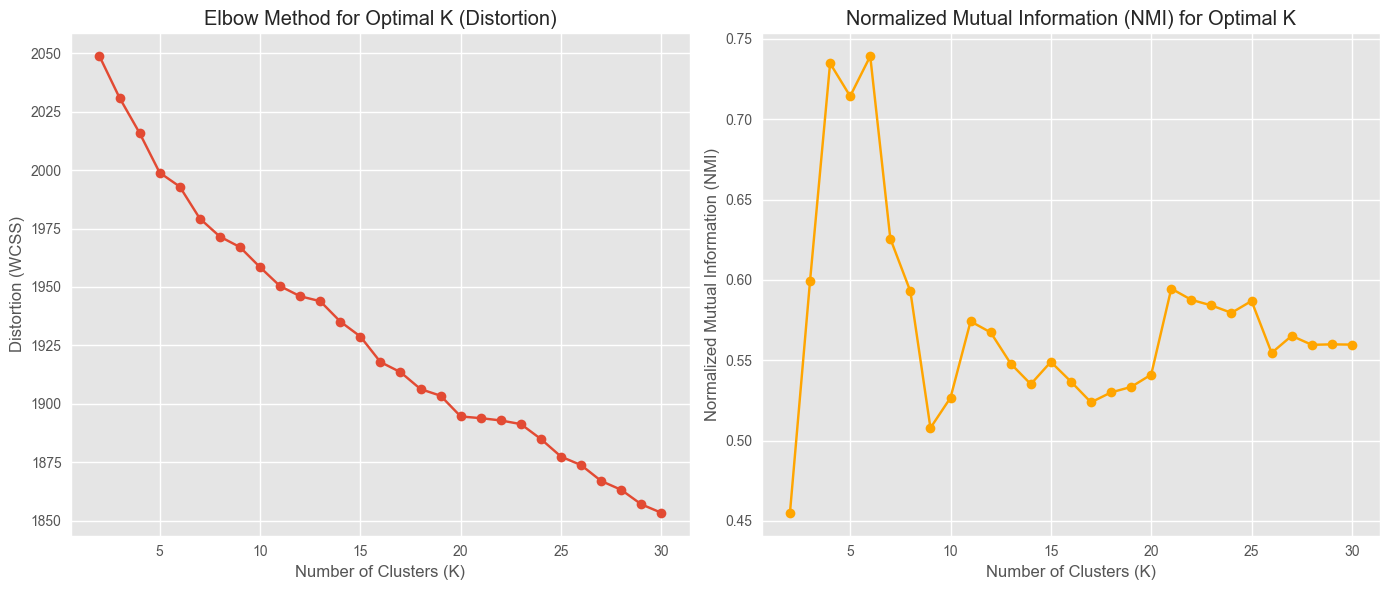

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
import numpy as np


K_range = range(2, 31)


distortions = []
nmi_scores = []

for k in K_range:

    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)


    distortions.append(kmeans.inertia_)


    nmi = normalized_mutual_info_score(df['category'], labels)
    nmi_scores.append(nmi)


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(K_range, distortions, marker='o')
plt.title("Elbow Method for Optimal K (Distortion)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Distortion (WCSS)")


plt.subplot(1, 2, 2)
plt.plot(K_range, nmi_scores, marker='o', color='orange')
plt.title("Normalized Mutual Information (NMI) for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Normalized Mutual Information (NMI)")


plt.tight_layout()
plt.show()


<div dir=ltr>
<font face="B Nazanin" size=4>
After selecting the optimal number of clusters, train the clustering model with this number. Then, add a column named <code>cluster</code> to the DataFrame that indicates the clusters predicted by the model for each sample.
</font>
</p>
</div>


In [ ]:
from sklearn.cluster import KMeans


optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, random_state=42)


df['cluster'] = kmeans.fit_predict(X_pca)


print(df[['content', 'category', 'cluster']].head())


                                             content  category  cluster
0   Quarterly profits at US media giant TimeWarne...  business        2
1   The dollar has hit its highest level against ...  business        2
2   The owners of embattled Russian oil giant Yuk...  business        2
3   British Airways has blamed high fuel prices f...  business        2
4   Shares in UK drinks and food firm Allied Dome...  business        2


In [ ]:
pickle.dump(df, open("clustered_df.pkl", "wb"))

In [ ]:
df = pickle.load(open("clustered_df.pkl", "rb"))

<div dir=ltr>
<h4>
<font face="B Nazanin">
<b>Clustering Visualization</b>
</font>
</h4>
<div dir=ltr>
<font face="B Nazanin" size=4>
Use the <code>t-SNE</code> algorithm to reduce the dimensions of the feature matrix to 2 dimensions and plot the clustering diagram.
</font>
</p>
</div>


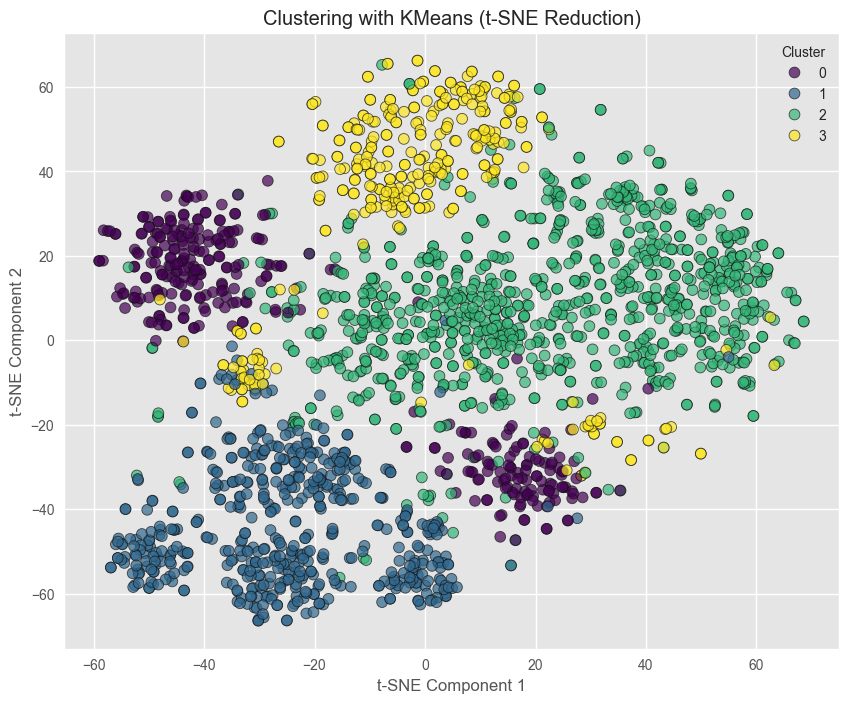

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns


tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)


df['tsne_1'] = X_tsne[:, 0]
df['tsne_2'] = X_tsne[:, 1]


plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='cluster', data=df, palette='viridis', s=60, alpha=0.7, edgecolor='k')


plt.title("Clustering with KMeans (t-SNE Reduction)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Cluster')
plt.show()


<div dir=ltr>
<font face="B Nazanin" size=4>
In four lines or fewer, explain the working of the t-SNE algorithm intuitively. There's no need to mention any symbols or mathematical relations.
</font>
</p>
</div>



<font face="B Nazanin">
<div dir=ltr>
<p align="justify">
<font size=4>
<b> <font color='#eb4034'>Explanation of the Answer: </font></b>  
In this algorithm, a metric is defined first, and then two data points, x and y, are considered. A formula for p(y|x) is created, where points that are closer to each other have a higher probability. This expression indicates how likely it is that y is a neighbor of x. Then, for each data point, a 2D representation (based on PCA) is created, and the same probability is calculated for these points. The algorithm then tries to minimize the difference between these probabilities for every pair of points.
</p>
</font>
</div>
</font>
<hr>


<div dir=rtl>
<h2>
<font face="B Nazanin" color="#0099cc">
Topic Modeling

<div dir=ltr>
<font face="B Nazanin" size=4>
Study the two topic modeling algorithms, <code>Latent Dirichlet Allocation</code> and <code>Non-Negative Matrix Factorization</code>, and briefly explain how each works (without the need to reference mathematical details). Then, choose one of these algorithms to proceed with.
</font>
</p>
</div>


<font face="B Nazanin">
<div dir=ltr>
<p align="justify">
<font size=4>
<b> <font color='#eb4034'>Explanation of the Answer: </font></b>  
NMF Algorithm:  
In this algorithm, our input is an m x n matrix, where m is the number of documents and n is the number of words. The algorithm decomposes this matrix into two matrices A and B. Matrix A is an m x t matrix, where t is the number of topics we provide to the algorithm. The elements of A represent the weight of each topic in each document. Matrix B is a t x n matrix, where the elements represent the weight of each word in each topic.

LDA Algorithm:  
In this algorithm, we aim to find the probabilistic distribution of topics in each document and words in each topic. First, we randomly assign a topic to each word in a document (a word may be assigned multiple topics). Then, we try to minimize two criteria: one is the diversity of topics for each word, and the other is the diversity of topics for each document. In each iteration, we adjust the topic of each word based on these two criteria until we reach the desired result.
</p>
</font>
</div>
</font>
<hr>


<div dir=ltr>
<font face="B Nazanin" size=4>
Topic modeling should be performed on the data of each cluster separately.  
Make sure that when using the <code>gensim</code> library, you first need to create the dictionary and BoW (Bag of Words) for each cluster.
</font>
</p>
</div>


In [ ]:
# TODO - make Dictionary and Corpus for each cluster
from gensim import corpora
from gensim.models import LdaModel
import pickle





def lda_per_cluster(df, num_topics=5):
    lda_models = {}
    for cluster_id in df['cluster'].unique():
        print(f"Processing cluster {cluster_id}...")


        cluster_data = df[df['cluster'] == cluster_id]['final'].tolist()


        dictionary = corpora.Dictionary(cluster_data)
        corpus = [dictionary.doc2bow(tokens) for tokens in cluster_data]


        lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)
        lda_models[cluster_id] = lda_model


        print(f"Topics for cluster {cluster_id}:")
        for idx, topic in lda_model.print_topics(-1):
            print(f"Topic {idx+1}: {topic}")
        print("\n")
    return lda_models


lda_models = lda_per_cluster(df, num_topics=5)


Processing cluster 2...
Topics for cluster 2:
Topic 1: 0.005*"company" + 0.005*"country" + 0.005*"government" + 0.005*"firm" + 0.004*"report" + 0.004*"market" + 0.003*"world" + 0.003*"business" + 0.003*"state" + 0.003*"high"
Topic 2: 0.008*"economy" + 0.008*"growth" + 0.008*"market" + 0.007*"price" + 0.007*"rate" + 0.007*"bank" + 0.007*"economic" + 0.006*"month" + 0.006*"fall" + 0.006*"sale"
Topic 3: 0.011*"party" + 0.011*"labour" + 0.010*"election" + 0.008*"government" + 0.008*"blair" + 0.007*"minister" + 0.004*"brown" + 0.004*"howard" + 0.004*"public" + 0.004*"prime"
Topic 4: 0.008*"government" + 0.007*"yukos" + 0.006*"company" + 0.006*"pay" + 0.004*"firm" + 0.004*"oil" + 0.004*"tax" + 0.004*"russian" + 0.004*"group" + 0.004*"deutsche"
Topic 5: 0.006*"company" + 0.006*"government" + 0.006*"country" + 0.004*"world" + 0.004*"report" + 0.004*"firm" + 0.003*"group" + 0.003*"business" + 0.003*"airline" + 0.003*"fiat"


Processing cluster 3...
Topics for cluster 3:
Topic 1: 0.008*"mail" + 

<div dir=ltr>
<font face="B Nazanin" size=4>
Next, you should find the optimal number of topics for each cluster by evaluating the Topic Coherence under the <code>C_V</code> metric.  
Keep the model that has the highest value of the metric for each cluster.  
<br>
It is sufficient to check the number of topics for 5, 10, 15, 20, and 25.
</font>
</p>
</div>


In [ ]:
import gensim
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from collections import defaultdict


topic_numbers = [5, 10, 15, 20, 25]


best_models = {}
best_coherences = {}

for cluster in df['cluster'].unique():

    cluster_tokens = df[df['cluster'] == cluster]['final'].tolist()


    dictionary = Dictionary(cluster_tokens)


    bow_corpus = [dictionary.doc2bow(tokens) for tokens in cluster_tokens]


    coherence_scores = []
    models = []


    for num_topics in topic_numbers:

        lda_model = LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=num_topics, random_state=42)


        coherence_model = CoherenceModel(model=lda_model, corpus=bow_corpus, dictionary=dictionary, coherence='c_v', texts=cluster_tokens)
        coherence_score = coherence_model.get_coherence()


        coherence_scores.append(coherence_score)
        models.append(lda_model)


    best_index = coherence_scores.index(max(coherence_scores))
    best_models[cluster] = models[best_index]
    best_coherences[cluster] = coherence_scores[best_index]


    print(f"Best model for Cluster {cluster}:")
    print(f"Number of Topics: {topic_numbers[best_index]}")
    print(f"Best Coherence Score (C_V): {best_coherences[cluster]}")
    print("="*50)




Best model for Cluster 2:
Number of Topics: 25
Best Coherence Score (C_V): 0.29868914823407694
Best model for Cluster 3:
Number of Topics: 25
Best Coherence Score (C_V): 0.2820354795379629
Best model for Cluster 1:
Number of Topics: 10
Best Coherence Score (C_V): 0.3827876252701781
Best model for Cluster 0:
Number of Topics: 15
Best Coherence Score (C_V): 0.29170662088560295


<div dir=ltr>
<font face="B Nazanin" size=4>
Briefly explain how the <code>C_V</code> metric is calculated.
</font>
</p>
</div>


<font face="B Nazanin">
<div dir=ltr>
<p align="justify">
<font size=4>
<b> <font color='#eb4034'>Explanation of the Answer: </font></b>  
This metric measures the coherence and interpretability of the topics identified by the model.  
We want to understand how related and meaningful the words identified within a topic are, so they are comprehensible to humans, allowing us to infer the topic of a given set of extracted words.  
This metric evaluates the co-occurrence of words within a topic. The co-occurrence is measured based on how often words appear together in different documents.  
Calculation process:  
From the topic modeling model, n top words are selected for each topic. These words are most likely to have the highest probability in that topic.  
Then, the co-occurrence between different words is calculated. This co-occurrence is typically measured by assessing how often words appear together in a set of documents (texts).  
Finally, the CV is calculated as the average co-occurrence between all pairs of selected words.
</p>
</font>
</div>
</font>
<hr>


<div dir=ltr>
<h4>
<font face="B Nazanin">
<b>Extraction of Topic Keywords</b>
</font>
</h4>
<div dir=ltr>
<font face="B Nazanin" size=4>
Next, for each data in the dataframe, you need to extract the top 3 topics that the model has predicted. Then, extract 2 important keywords from each topic.
</font>
</p>
</div>


In [ ]:
import pandas as pd


def extract_top_topics_and_keywords(df, best_models):

    top_topics_list = []
    top_words_list = []


    for cluster in df['cluster'].unique():

        lda_model = best_models[cluster]


        for idx, row in df[df['cluster'] == cluster].iterrows():

            tokens = row['final']
            bow = lda_model.id2word.doc2bow(tokens)


            topic_probabilities = lda_model.get_document_topics(bow)


            sorted_topics = sorted(topic_probabilities, key=lambda x: x[1], reverse=True)[:3]


            topic_keywords = []
            for topic_id, _ in sorted_topics:

                topic_terms = lda_model.show_topic(topic_id, topn=10)
                top_keywords = [word for word, prob in topic_terms[:2]]
                topic_keywords.extend(top_keywords)


            top_topics_list.append([topic_id for topic_id, _ in sorted_topics])
            top_words_list.append(topic_keywords)

    # افزودن به دیتافریم
    df['top_topics'] = top_topics_list
    df['top_words'] = top_words_list

    return df


df = extract_top_topics_and_keywords(df, best_models)

print(df[['content', 'cluster', 'top_topics', 'top_words']].head())


                                             content  cluster   top_topics  \
0   Quarterly profits at US media giant TimeWarne...        2  [13, 17, 1]   
1   The dollar has hit its highest level against ...        2    [9, 1, 8]   
2   The owners of embattled Russian oil giant Yuk...        2     [11, 13]   
3   British Airways has blamed high fuel prices f...        2          [1]   
4   Shares in UK drinks and food firm Allied Dome...        2      [19, 8]   

                                           top_words  
0        [sale, yukos, company, firm, bank, economy]  
1  [government, minister, bank, economy, election...  
2                   [government, party, sale, yukos]  
3                                    [bank, economy]  
4               [firm, government, election, labour]  


In [ ]:
final_df= pd.DataFrame()
final_df['top_keywords'] = df['top_words'].apply(lambda words: '|'.join(words))
final_df['cluster'] = df['cluster']
final_df['x'] = df['tsne_1']
final_df['y'] = df['tsne_2']

In [ ]:
pickle.dump(final_df, open("final_df.pkl", "wb"))

In [ ]:
final_df = pickle.load(open("final_df.pkl", "rb"))

<div dir=ltr>
<h2>
<font face="B Nazanin" color="#0099cc">
Displaying Clusters and Topics
</font>
</h2>
</div>


<div dir=ltr>
<font face="B Nazanin" size=4>
Using the code provided below, you can view the charts related to clustering and topics.  
<br>
<font color='#eb4034'>
The structure of the dataframe passed to the code below must be exactly as follows:
</font>
</font>
</p>
</div>

<center>
<table style="direction: rtl;align: center; text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
  <tr>
      <td><code>x</code></td><td>Column x of the feature matrix, reduced to 2 dimensions using TSNE</td>
  </tr>
<tr>
      <td><code>y</code></td><td>Column y of the feature matrix, reduced to 2 dimensions using TSNE</td>
  </tr>
<tr>
      <td><code>cluster</code></td><td>The predicted cluster for the data</td>
  </tr>
<tr>
      <td><code>top_keywords</code></td><td>The extracted keywords for the data*</td>
</table>
</center>

<div dir=ltr>
<font face="B Nazanin" size=4>
<br>
*Note that the values in this column must be of type <code>string</code> and separated by the <code>|</code> symbol.  
For example:  
<code>word1|word2|word3</code>
</font>
</p>
</div>


  

In [ ]:
import dash
from dash import dcc, html, Input, Output
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

df_dash = final_df.copy()

# Split the keywords for processing
df_dash['keywords_list'] = df_dash['top_keywords'].str.split('|')

# Initialize Dash app
app = dash.Dash(__name__)

# Create the layout
app.layout = html.Div([
    html.Div([
        html.H4(" t-SNE Plot with Keyword Search"),
        dcc.Graph(id='scatter-plot'),
        html.Label("Search for a keyword:"),
        dcc.Input(id='keyword-search', type='text', placeholder='Enter keyword', debounce=True),
    ], style={'width': '75%', 'display': 'inline-block', 'backgroundColor': '#ffffff'}),

    html.Div([
        html.H4(" Most Frequent Keywords"),
        html.Div(id='keyword-panel', style={'backgroundColor': '#f0f0f5', 'padding': '10px', 'borderRadius': '5px'})
    ], style={'width': '25%', 'display': 'inline-block', 'verticalAlign': 'top', 'backgroundColor': '#f0f0f5'})
])

# Callback for updating the scatter plot
@app.callback(
    Output('scatter-plot', 'figure'),
    [Input('keyword-search', 'value')]
)
def update_scatter(search_keyword):
    # Create a highlight column based on the search keyword
    if search_keyword:
        df_dash['highlight'] = df_dash['keywords_list'].apply(lambda x: any(search_keyword.lower() in k.lower() for k in x))
    else:
        df_dash['highlight'] = True  # Highlight all points if no keyword is searched

    # Prepare data for plotting
    highlighted_df = df_dash[df_dash['highlight']]
    non_highlighted_df = df_dash[~df_dash['highlight']]

    # Create scatter plot with highlighted and non-highlighted points
    fig = go.Figure()

    # Add non-highlighted points (gray color)
    fig.add_trace(go.Scatter(
        x=non_highlighted_df['x'],
        y=non_highlighted_df['y'],
        mode='markers',
        marker=dict(color='gray', size=8, opacity=0.4),
        name='Non-Highlighted',
        text=non_highlighted_df['top_keywords'],  # Add top_keywords to hover
        hoverinfo='text'  # Show only the top_keywords on hover
    ))

    # Add highlighted points with cluster colors
    for cluster in df_dash['cluster'].unique():
        cluster_df = highlighted_df[highlighted_df['cluster'] == cluster]
        fig.add_trace(go.Scatter(
            x=cluster_df['x'],
            y=cluster_df['y'],
            mode='markers',
            marker=dict(size=8, opacity=0.8),
            name=f'Cluster {cluster}',
            marker_color=px.colors.qualitative.Light24[cluster],
            text=cluster_df['top_keywords'],  # Add top_keywords to hover
            hoverinfo='text'  # Show only the top_keywords on hover
        ))

    # Update layout
    fig.update_layout(
        title="t-SNE Plot",
        xaxis_title="X",
        yaxis_title="Y",
        legend_title="Legend",
        height=800,
        width=1000
    )

    return fig

# Callback for updating the keyword panel
@app.callback(
    Output('keyword-panel', 'children'),
    [Input('scatter-plot', 'figure')]
)
def update_keyword_panel(_):
    # Flatten the list of keywords and compute most frequent ones
    all_keywords = [keyword for keywords in df_dash['keywords_list'] for keyword in keywords]
    keyword_counts = pd.Series(all_keywords).value_counts().head(40)
    return [html.Li(f"{kw}: {count}") for kw, count in keyword_counts.items()]


# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, jupyter_height=1200, port=8050)


<div dir=rtl>
<h2>
<font face="B Nazanin" color="#0099cc">
Word Clouds

<div dir=ltr>
<font face="B Nazanin" size=4>
In this section, you need to plot the Word Clouds for the keywords of each cluster.

First, you need to find the frequency of the keywords for each cluster.  
(Only consider the top 10 keywords from each topic)  
Then, using the keywords and their frequency, plot the Word Clouds.
</font>
</p>
</div>



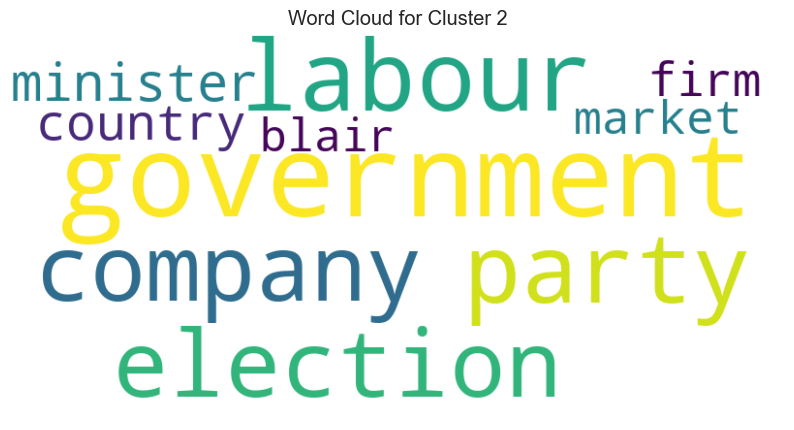

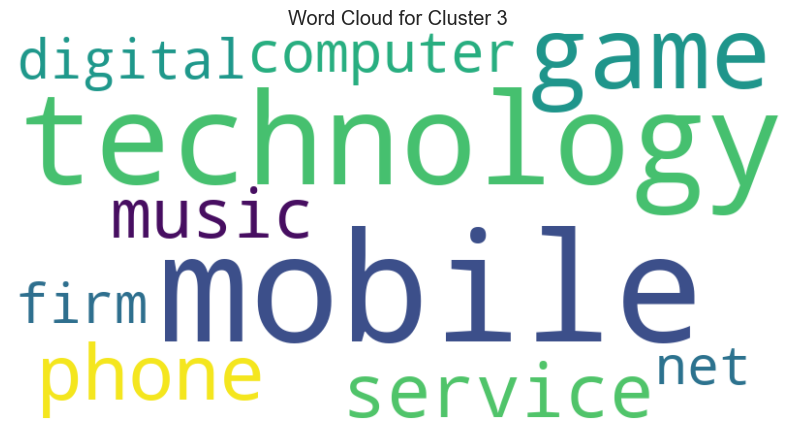

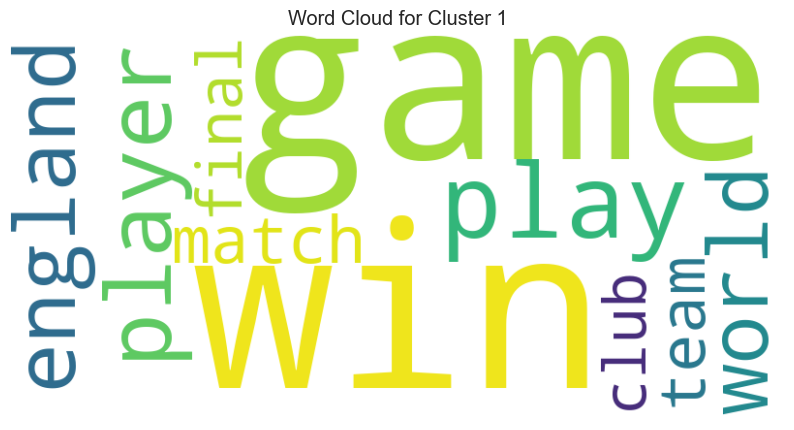

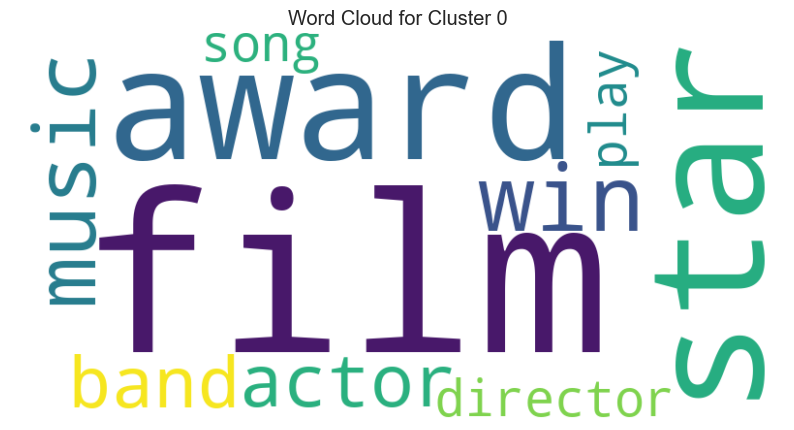

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

def get_top_keywords_by_cluster(df):

    cluster_keywords = {}


    for cluster in df['cluster'].unique():

        all_keywords = []

        for idx, row in df[df['cluster'] == cluster].iterrows():

            tokens = row['final']
            all_keywords.extend(tokens)


        keyword_counts = Counter(all_keywords)


        cluster_keywords[cluster] = keyword_counts

    return cluster_keywords


def plot_wordcloud_for_clusters(cluster_keywords):
    for cluster, keyword_counts in cluster_keywords.items():

        top_keywords = dict(keyword_counts.most_common(10))


        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_keywords)


        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Cluster {cluster}")
        plt.show()


cluster_keywords = get_top_keywords_by_cluster(df)
plot_wordcloud_for_clusters(cluster_keywords)
